# Enova EMS_Beregningskjerne (Brukerhistorie)
Nima Darabi - Webstep - July - September 2021

In [36]:
import networkx as nx
import matplotlib.pyplot as plt
#import pygraphviz
#import pydot
from networkx.drawing.nx_agraph import graphviz_layout
import re
import random

def writechildren (s):
    for tuple in dependency_graph:
        if s ==tuple[0]:
            a.append(tuple)
            if not tuple[1].isnumeric():
                writechildren (tuple[1])

def hierarchy_pos_modified(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5 ):
    def h_recur(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5,
                  pos = None, parent = None, parsed = [] ):
        if(root not in parsed):
            parsed.append(root)
            if pos == None:
                pos = {root:(xcenter,vert_loc)}
            else:
                pos[root] = (xcenter, vert_loc)
            neighbors = G.neighbors(root)
            if parent != None:
                neighbors.remove(parent)
            if len(neighbors)!=0:
                dx = width/len(neighbors)
                nextx = xcenter - width/2 - dx/2
                for neighbor in neighbors:
                    nextx += dx
                    pos = h_recur(G,neighbor, width = dx, vert_gap = vert_gap,
                                        vert_loc = vert_loc-vert_gap, xcenter=nextx, pos=pos,
                                        parent = root, parsed = parsed)
        return pos

def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')
    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))
    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)
        if len(children)!=0:
            dx = width/len(children)
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap,
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [37]:
# Extract all relations
filename = "/Users/nimadarabi/Desktop/Projects/Enova/Energimerkeordningen/EnergiBeregning.py"
with open(filename) as file:
    lines = file.readlines()
    lines = [line.rstrip() for line in lines]

dependency_graph = []

allterminals = set([])
allnonterminals = set([])
alllines = set([])
keywords = ['log','max','mean','nan', 'np','self', 'pi', 'sum', 'else', 'exp', 'if']

namedict = {}
reldict = {}
for line in lines:
    if line.find("=") > -1:
        line = line.strip()
        index1 = line.find("=")
        after = line[index1+1: ]
        cell = line[0 : index1-1]
        if cell.find("#") == -1:
            index2 = after.find("#")
            formula = after[0:index2] if index2 > -1 else after[0:]
            description = after[index2+1 : ]
            namedict[cell] = description
            nonterminal_pattern = '[A-Z]+[0-9]+'
            terminal_pattern = '[a-zA-Z]+[a-zA-Z_0-9]*'
            nonterminals = re.findall(nonterminal_pattern, formula)
            terminals = re.findall(terminal_pattern, formula)
            terminals = list(set(terminals) - set(keywords))
            #re.findall('[a-zA-Z]+[a-zA-Z_0-9]*', ' self.energibehov_tappevann  ')
            allterminals    = allterminals   .union(set(terminals))
            allnonterminals = allnonterminals.union(set(nonterminals))
            alllines = alllines.union(set([line]))
            nextcells = nonterminals + terminals
            for destination in nextcells:
                if cell != destination:
                    dependency_graph.append((cell, destination, line))
dependency_graph = list(set(dependency_graph))
print (len(dependency_graph))

2179
2179


4


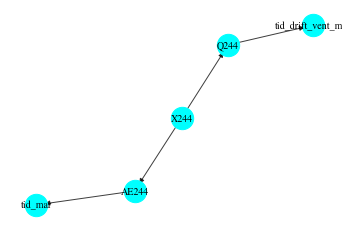

In [41]:
# Extract the calculation of a given cell
a = []
writechildren ('X244') # C20 C22 C49 term49 X64 Q254 Q247
print (len(a))

# Construct the graph
edges = [(i[0],i[1],1) for i in a]
if 0: print(*edges, sep='\n')
G=nx.DiGraph()
G.add_weighted_edges_from(edges)

pos=nx.circular_layout(G) # 3. default solution
pos=nx.random_layout(G)
pos=nx.spectral_layout(G)
pos=nx.spring_layout(G)
#pos = hierarchy_pos_modified(G,1)      # 1. local function solution
#pos = graphviz_layout(G, prog="twopi") # 2. pydot solution "dot" "circo"

if 0:
    p=nx.drawing.nx_pydot.to_pydot(G)
    p.write_png('./example.png')

nx.draw_networkx_nodes(G,pos,node_size=500, node_color='cyan')
nx.draw_networkx_edges(G,pos,edgelist=a,width=1,alpha=0.75,edge_color='k',style='solid') #dotted
nx.draw_networkx_labels(G,pos,font_size=10,font_family='Times')
plt.axis('off')
plt.savefig("/Users/nimadarabi/Desktop/brukerhistorie.png", dpi=300) # save as png
plt.show() 

In [39]:
# https://observablehq.com/@d3/force-directed-graph